<a href="https://colab.research.google.com/github/wujj0326/Injury_text_classifier/blob/master/Injury_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Injury monitoring transfer learning


## Import modules

In [0]:
import csv, itertools, nltk, numpy as np, os, pandas as pd, re, requests, time, unicodedata
nltk.download("stopwords")
from nltk.corpus import stopwords
import json
import requests
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from collections import Counter, OrderedDict
plt.style.use('ggplot')
import operator
from random import sample

## Load data

Loads file from https://dgoldberg.sdsu.edu/data/neissdata.csv, which includes NEISS data for 2015, 2016, 2017, and 2018.

The "Narrative_1" and "Narrative_2" fields from the original NEISS data have been concatenated into one field ("Narrative").

The data is stored in a 2D list called `data`. Each row represents a unique record. Columns are organized as follows:
* 0: CPSC_Case_Number
* 1: Treatment_Date
* 2: Age
* 3: Sex
* 4: Race
* 5: Other_Race
* 6: Body_Part
* 7: Diagnosis
* 8: Other_Diagnosis
* 9: Disposition
* 10: Location
* 11: Fire_Involvement
* 12: Product_1
* 13: Product_2
* 14: Narrative
* 15: Stratum
* 16: PSU
* 17: Weight

In [0]:
# Record start time
start_time = time.time()

# Initialize data container
data = []

# Download data from web - this may take a few seconds
response = requests.get("https://dgoldberg.sdsu.edu/data/neissdata.csv")

# Data download was successful
if response:
    lines = response.text.splitlines()

    # Load into 2D list (data)
    # Headers are stored separately (headers)
    reader = csv.reader(lines)
    for i, line in enumerate(reader):
        if i == 0:
            headers = line
        else:
            data.append(line)

    # Calculate, print time elapsed
    end_time = time.time()
    print(f"Data downloaded in {round(end_time - start_time, 2)} seconds.")

# Connection error
else:
    print(f"Connection error: <{response.status_code}>.")

Data downloaded in 20.18 seconds.


In [0]:
len(data[0])

18

In [0]:
len(data)

1482899

## Clean data

Declares functions to clean the data by converting to ASCII, removing punctuation, normalizing casing, removing stop words, and removing age and gender text.

In [0]:
'''
The reason that I need to replace the abbreviation before cleaning the punctuation is because, for example, "d.x." is the abbreviation of diagnosis. 
Ideally, I wanted to get rid of all the punctuation to make our model more accurate. 
However, if I removed the punctuation before I replaced the words, "d.x." would be split as "d x " and it would become more difficult to replace it ever since.
Moreover, I have to replace it seperately because for the abbreviation without punctuation, I could only replace the abbreviation that match fully to the dictionary key.
For example, I want to replace "ed" which means "emergency department", nevertheless, if I replace the word by using the re.sub 
or the way I replace the abbreviations with punctuation,
the words with "ed" such as "played" would be removed as well.
'''

punc_conversions = {"d.x.":" diagnosis ",
                    ".dx":"  diagnosis ",
                    "dx.":" diagnosis ",
                    "dx:":" diagnosis ",
                    ' d x:':" diagnosis ",
                    'h/o':" history of ",
                    "f.x.": " fracture ",
                    "fx.": " fracture ",
                    ".fx": " fracture ",
                    "c/o": " complains of",
                    "s/p": " no change after ",
                    "w/o":" without ",
                    "w/":" with ",
                    'p/w':' presents with ',
                    "l.o.c": " loss of consciousness ",
                    'b/l':' bilateral ',
                    #  "t'd&f":"", # this one would cause 't' 'd' 'f' to be calculated, but I couldn't find the answer
                    'r/o':' rule out '}

In [0]:
norm_conversions = {
              "dx":'diagnosis',
               "lac": "laceration",
               "fx": "fracture",
               "pt": "patient",
               "c": "with",
               'yf':'year f',
               'mf':'month f',
               'ym':'year m',
               'mm':'month m',
               "w": "with",
               "l": "left",
               "r": "right",
               "rt": "right",
               "lt": "left",
               "p": "after",
               "chi": "closed head injury",
              "loc":"loss consciousness", # should be loss of consciousness, but 'of' is an useless stopword 
               "inj": "injured",
               "cont": "contusion", #?
               "fb": "foreign body", #?
               "pn": "pain", #?
               "sust": "sustained",
               'ap':'before dinner',
               "acc": "accident",
               "ft": "foot", #Unit of measurment, not limb.
               "cm": "centimeter",
               "str": "strain",
               "etoh": "ethanol", #Alcohol
               "pta": "physical therapist assistants",
               "st": "first",
               "nd": "second",
               'hx':'history',
              #  'sts':'serological test for syphilis', # this is definitely not the right answer, but this is the most general one in every medical dict
               "homedx": "home diagnosis",
               'sx':'symptom',
               "px": "prognosis",
               "ed": "emergency department"
               }

In [0]:
def unicode_to_ascii(unicode_string):
    """Converts a Unicode string to ASCII.
        Returns an ASCII string.
    
    s - the string to convert."""

    return "".join(c for c in unicodedata.normalize("NFD", unicode_string) if unicodedata.category(c) != "Mn")


def preprocess_sentence(sentence):
    """Preprocesses sentence strings by removing non-alphabetic characters.
    Removes age and gender text from beginning of sentence strings.
        Returns a preprocessed string.
    
    sentence - the string to preprocess."""

    # Convert to ASCII
    sentence = unicode_to_ascii(sentence.lower().strip())

    # 1st abbreviation replacement
    words = sentence.split(" ")
    sent = []
    for word in words:
      for j in range(len(list(punc_conversions.keys()))):
        keys = list(punc_conversions.keys())[j]
        if keys in word:
          values = list(punc_conversions.values())[j]
          word = word.replace(keys,values)
        else: pass
      sent.append(word)
    sentence = " ".join(sent)

    # Create a space between each word and the punctuation following it.
    # For example: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sentence = re.sub(r"([?.!,¿'/;:-])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    

    
    # Removes non-alphabetic characters
    sentence = re.sub(r"[^a-zA-Z]+", " ", sentence)

    # 2nd abbreviation replacement 
    words = sentence.split(' ')
    sent=[]
    for word in words:
      if word in norm_conversions.keys():
        new_2nd_word = norm_conversions.get(word,word)
      else: new_2nd_word=word
      sent.append(new_2nd_word)
    sentence = " ".join(sent)

    # Removes all stop words
    stop_list = [word for word in stopwords.words('english') if len(word)>1 or word=='a']
    stop_list = stop_list+['th', 'nd']
    pattern = re.compile(r"\b(" + r"|".join(stop_list) + r")\b\s*")  
    sentence = re.sub(pattern, "", sentence)

    # Removes age and gender text from the beginning of sentence strings
    for first_word in ['white','hisp','ld','yo','mo']:
      for second_word in ['female','male','f','m']:
        sentence = re.sub(first_word + " " + second_word,"", sentence)
        sentence = re.sub(first_word + second_word,"", sentence)    
    sentence = re.sub("female","", sentence)
    sentence = re.sub("male","", sentence)
    sentence = re.sub("y o m","", sentence)
    sentence = re.sub("y o f","", sentence)
    sentence = re.sub("m o m","", sentence)
    sentence = re.sub("m o f","", sentence)
    for first_word in ["year", "month", "week", "day","yr", "wk"]:
        for second_word in ["old", "ol","o", "s"]:
            for third_word in ["f", "m"]:
                sentence = re.sub(first_word + " " + second_word + " " + third_word, "", sentence)
                sentence = re.sub(first_word + second_word + " " + third_word, "", sentence)
                sentence = re.sub(first_word + " " + second_word + third_word, "", sentence)
                sentence = re.sub(first_word + second_word + third_word, "", sentence)
                sentence = re.sub(first_word + " " + third_word, "", sentence)
                # sentence = re.sub(first_word + third_word, "", sentence)
            sentence = re.sub(first_word + " " + second_word, "", sentence)
            # sentence = re.sub(first_word + second_word, "", sentence)
    for first_word in ['y/o','m/o']:
      for second_word in ['f','m']:
        sentence = re.sub(first_word + " " + second_word,"", sentence)
        sentence = re.sub(first_word + second_word,"", sentence)
    sentence = sentence.rstrip().strip()
    return sentence


def clean_lines(data, n_samples = -1, verbose = False):
    """Uses helper functions to preprocess and clean a 2D list of data.

    data - a 2D list containing all records whose narrative field is in index 14.
    n_samples - the number of lines to clean.
        If n_samples is not specified, then all of data is cleaned.
    verbose - whether to show a printout with a progress update periodically.
        If not specified, verbose is assumed False."""
    
    # Handle default
    if n_samples == -1:
        n_samples = len(data)

    # Extract column 14 (narrative field)
    # Clean field and store as sentence and as distinct words
    cleaned_sentences = []
    cleaned_words = []

    # Set up verbose output
    if verbose:
        cutoffs = [n_samples / (6 - i) for i in range(1, 6)]
        percentages = [i for i in range(20, 101, 20)]
        print("Preprocessing text.\n0% completed.")

    for i, obs in enumerate(data[:n_samples]):
        sentence = obs[14]
        # sentence = obs
        cleaned_sentence = preprocess_sentence(sentence)
        cleaned_sentences.append(cleaned_sentence)
        cleaned_word = cleaned_sentence.split()
        cleaned_words.append(cleaned_word)

        # Update completion percentage for verbose output
        if verbose:
            if i + 1 >= cutoffs[0]:
                print(f"{percentages[0]}% completed.")
                del cutoffs[0]
                del percentages[0]

    return cleaned_sentences, cleaned_words

Cleans the dataset.

In [0]:
# Record start time
start_time = time.time()

# Clean dataset
sentences, words = clean_lines(data ,verbose = True) # All data! May take a while

# Calculate, print time elapsed
end_time = time.time()
print(f"Text preprocessed in {round(end_time - start_time, 2)} seconds.")

Preprocessing text.
0% completed.
20% completed.
40% completed.
60% completed.
80% completed.
100% completed.
Text preprocessed in 974.45 seconds.


Identifies and shows the 250 most frequently used words.

In [0]:
# Set up containers
words_flat = list(itertools.chain.from_iterable(words)) 
freq = {}

# Calculate frequencies
for word in words_flat:
    if word in freq:
        freq[word] = freq[word] + 1
    else:
        freq[word] = 1

# Descriptive statistics
print(f"The dataset contains {len(words_flat)} total words and {len(freq)} unique words.")

# Show top 250 words and percentages of reports containing them
sorted_frequencies = sorted(freq.items(), key = lambda x: x[1], reverse = True)

for result in sorted_frequencies[:250]:
    print(f"{result[0]}: {round(result[1] / len(sentences) * 100, 2)}%")

The dataset contains 14982104 total words and 141757 unique words.
diagnosis: 52.47%
fell: 35.96%
head: 22.83%
pain: 22.27%
laceration: 19.61%
left: 17.9%
right: 17.89%
fracture: 14.66%
hit: 13.01%
injury: 12.22%
floor: 11.85%
playing: 11.2%
patient: 10.74%
finger: 10.62%
contusion: 10.38%
home: 9.76%
ankle: 9.02%
knee: 8.91%
back: 8.86%
foot: 8.82%
hand: 8.55%
complains: 8.06%
onto: 7.13%
sprain: 6.7%
closed: 6.65%
bed: 5.99%
injured: 5.53%
fall: 5.42%
shoulder: 5.27%
face: 5.23%
leg: 4.96%
wrist: 4.94%
strain: 4.62%
lower: 4.62%
hitting: 4.59%
arm: 4.4%
sustained: 4.34%
tripped: 4.24%
stairs: 4.09%
slipped: 4.04%
hip: 3.92%
cut: 3.88%
basketball: 3.83%
elbow: 3.67%
chest: 3.63%
change: 3.6%
wall: 3.53%
steps: 3.38%
loss: 3.32%
toe: 3.3%
consciousness: 3.29%
door: 3.26%
ago: 3.08%
chair: 3.05%
body: 3.05%
football: 2.91%
walking: 2.83%
scalp: 2.73%
forehead: 2.72%
struck: 2.71%
school: 2.7%
foreign: 2.69%
neck: 2.66%
table: 2.59%
bike: 2.59%
s: 2.57%
got: 2.55%
riding: 2.4%
thumb: 2.3

To check the meaning of acronyms/abbreviations

In [0]:
def show_matches(search, sentences, words, n_matches = 10):
    matches = []
    for i, word_list in enumerate(words):
        if search in word_list:
            matches.append([sentences[i], data[i][14]])
        if len(matches) == 10:
            break

    for match in matches:
        print(match)

show_matches("d", sentences, words)

['t d f walking upstaris hitting face edge step laceration', "10YF T'D&F WHILE WALKING UPSTARIS HITTING FACE ON EDGE OF STEP>>LAC"]
['t d f walking stairs rolling ankle sprain', "18YF T'D&F WHILE WALKING DOWN STAIRS ROLLING ANKLE>>SPRAIN"]
['shopping t d f cutting finger edge metal shelf skin avulsion', "65YF WAS SHOPPING WHEN T'D&F CUTTING FINGER ON A EDGE OF METAL SHELF>>SKIN AVULSION"]
['lives alone fell bed floor d ago family called ems t show work pelvic fracture rhabdo', "71YM LIVES ?ALONE, FELL OUT OF BED TO THE FLOOR 2D AGO, FAMILY CALLED EMS AFTER DIDN'T SHOW UP FOR WORK>>PELVIC FX/RHABDO"]
['t d f flight stairs striking head loss consciousness n v laceration', "4YM T'D&F DOWN A FLIGHT OF STAIRS STRIKING HEAD NO LOC/N/V>>LAC"]
['change recent abd vag symptom presents dinner t d f flight stairs pain', "26YF S/P RECENT ABD/VAG SX, P/W AP AFTER T'D&F DOWN A FLIGHT OF STAIRS>>PAIN"]
['change unwit d fall bed fd onto floor humrus fracture', "78YF S/P UNWIT'D FALL OUT OF BED , FD DO

Code below takes the words in sorted_frequencies and finds 10 similar words for it. Once ten have been made, the word will be stored in a list along with the 10 similar words. These words that are generated can be modified in the response line, to get a better or more accurate similar word.

In [0]:
# Template for finding synonyms/related words
# From Nick

similar_words = []

for i in range(0,500,1): #This for loop can be easily modified to run through entire list, but for the sake of time, only 500 are generated.
  response = requests.get("https://api.datamuse.com/words?ml=" + sorted_frequencies[i][0] + "&topics=health medical"+"&max=5")
  if sorted_frequencies[i][0] in conversions:
    continue
  else:
    if response:
      temp_word = [sorted_frequencies[i][0]]   #Stores the base word into a temporary list.
      datas = json.loads(response.text)       #Once connection has been made, similar words to base word are stored into the temp list.
      for lines in datas:                     #up to 10 will be found and stored in the temp list. Once this is finished, the temp list is moved
        word_sim = lines["word"]             #into the similar words list, and the temp_list variable is recycled for the next word.
        if word_sim in conversions or word_sim == "":
          continue
        else:
          temp_word.append(word_sim)
      similar_words.append(temp_word)

    else:
      print(f"Connection error: <{response.status_code}.")
for convert in conversions:  #Since conversions is a short dict, the program just runs through the whole thing.
  response = requests.get("https://api.datamuse.com/words?ml=" + conversions[convert] + "&max=10") #Since conversions are stored in a seperate dictionary,
  temp_word = [conversions[convert]]                                                               #they are extracted and similar words are found seperately.
                                                                                                   #However, they are stored in the same similar words list.
  if response:
    datas = json.loads(response.text)
    for lines in datas:
      word_sim = lines["word"]
      
      temp_word.append(word_sim)  #Pretty much the same method for for the base words in the previous block of code. 
    similar_words.append(temp_word)
  else:
    print(f"Connection error: <{response.status_code}>.")

for i in range(0,10):      #Testing out put for the first 10 words.
  print(similar_words[i])

['fell', 'drop', 'hide', 'vanish', 'fly', 'brutal']
['pain', 'anguish', 'painfulness', 'hurting', 'hurt', 'annoyance']
['head', 'chief', 'principal', 'boss', 'top', 'forefront']
['hit', 'smash', 'bump', 'reach', 'shoot', 'bang']
['floor', 'storey', 'deck', 'level', 'stun', 'base']
['finger', 'thumb', 'pinky', 'digit', 'feel', 'fingerbreadth']
['&', 'atropine', 'clinic', 'cure', 'cured', 'family medicine']
['ankle', 'leg', 'sprained', 'ankle joint', 'articulatio talocruralis', 'mortise joint']
['back', 'backward', 'backwards', 'game', 'second', 'rear']
['knee', 'kneecap', 'genu', 'stifle', 'articulatio genus', 'knee joint']


## Visualization

In [0]:
# Dictionary for all the injury type and its corresponding ID
injury_dict = {'41' : 'INGESTION',
  '42' : 'ASPIRATION',
  '46' : 'BURN_ELECTRICAL',
  '47' : 'BURN_NOTSPEC',
  '48' : 'BURN_SCALD',
  '49' : 'BURN_CHEMICAL',
  '50' : 'AMPUTATION',
  '51' : 'BURNS_THERMAL',
  '52' : 'CONCUSSION',
  '53' : 'CONTUSION_ABRASION',
  '54' : 'CRUSHING',
  '55' : 'DISLOCATION',
  '56' : 'FOREIGN_BODY',
  '57' : 'FRACTURE',
  '58' : 'HEMATOMA',
  '59' : 'LACERATION',
  '60' : 'DENTAL_INJURY',
  '61' : 'NERVE_DAMAGE',
  '62' : 'INTERNAL_INJURY',
  '63' : 'PUNCTURE',
  '64' : 'STRAIN_SPRAIN',
  '65' : 'ANOXIA',
  '66' : 'HEMORRHAGE',
  '67' : 'ELECTRIC_SHOCK',
  '68' : 'POISONING',
  '69' : 'SUBMERSION',
  '70' : 'OTHER',
  '71' : 'OTHER',
  '72' : 'AVULSION',
  '73' : 'RADIATION',
  '74' : 'DERMA_CONJUNCT'}

Word Cloud for all words

In [0]:
sen_for_cloud = " ".join(text for text in sentences)
print ("There are {} words in the combination of all review.".format(len(sen_for_cloud)))

There are 102832735 words in the combination of all review.


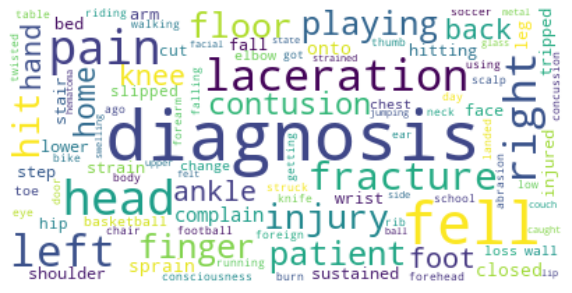

In [0]:

wordcloud = WordCloud(max_font_size=50,collocations=False, max_words=100,background_color="white").generate(sen_for_cloud)

# Display the generated image:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

make the new data to csv

In [0]:
# append the clean sentence to the new data list
new_data = data
for i, record in enumerate(new_data):
  record.append(sentences[i])

In [0]:
col_name = ['CPSC_Case_Number','Treatment_Date','Age','Sex','Race','Other_Race','Body_Part','Diagnosis',
'Other_Diagnosis','Disposition','Location','Fire_Involvement','Product_1','Product_2',
'Narrative','Stratum','PSU','Weight','clean_narrative']

In [0]:
with open ('/content/drive/My Drive/Injury_Monitoring/cleaned_text.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(col_name)
  writer.writerows(new_data)

Word Cloud for the specific injury type

In [0]:
def injured_count(dataset):
  e = []
  for ob in dataset:
    e.append(ob[7])
  counter_type = Counter(e)
  dict_count = dict(counter_type)
  new_dict = {}
  for key, val in injury_dict.items():
    new_dict[val] = dict_count.get(key)
  sorted_tuple = sorted(new_dict.items(), key=operator.itemgetter(1))
  sort_col = []
  sort_val = []
  for i in sorted_tuple:
    sort_col.append(i[0])
    sort_val.append(i[1])
  plt.figure(figsize=(8,7))
  plt.barh(sort_col, sort_val)
  # plt.xticks(rotation = 90)
  return plt.show()

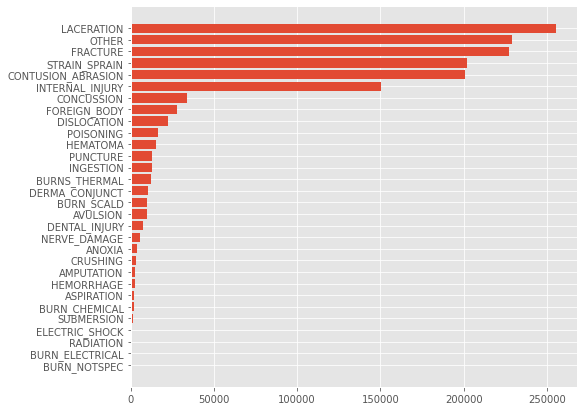

In [0]:
# The frequency of each type of injury
injured_count(new_data)

In [0]:
def injured_sent(dataset, injury_key):
  """This function could slice the specific injury type's narrative senetence to a list.
  and visualize the word cloud of the list"""
  blank = []
  for obs in dataset:
    if obs[7] == injury_key:
      blank.append(obs[-1])
    else: pass
  # the stopwords here obtain too much frequency and would make the wordcloud useless
  stop_injure = injury_dict[injury_key].split('_')
  try:
    stops = {'diagnosis', 'patient', stop_injure[0], 'right', 'left', stop_injure[1], 'onto'}
  except : stops = {'diagnosis', 'patient', stop_injure[0], 'right', 'left', 'onto'}
  sen_for_cloud = " ".join(text for text in blank)
  wordcloud = WordCloud(max_words=150, collocations=False,stopwords=stops,background_color="white").generate(sen_for_cloud)
  plt.figure(figsize=(10,8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('The word cloud for {}'.format(injury_dict[injury_key]))
  plt.axis("off")
  return blank, plt.show()

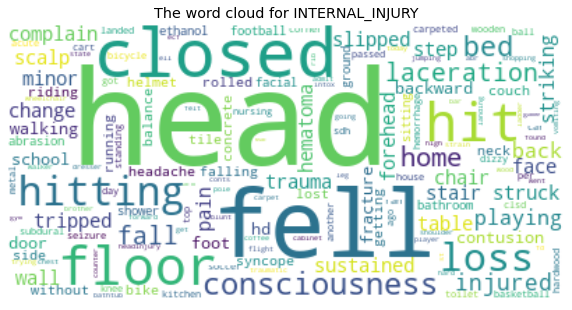

In [0]:
inj_list, arg = injured_sent(new_data, '62')

## Text Classifier

Train a logistic regression model on one balanced data set of category-specific reports (e.g. 10000 reports: 5000 laceration-related vs. 5000 no laceration-related reports) and then test the model on a test data set that contains another set of 10000 injury reports (5000 laceration-mentioned reports vs. 5000 no laceration-mentioned reports). Coming out with this kind of result will help the injury prevention experts at CPSC to know that a machine learning model will rapidly discover a higher percentage of category-specific injury reports than just manually identifying a set of category-spcific reports by humans from a very large pool of text data.

### Bineary Logistic Regression

In [0]:
injury_dict = {'41' : 'INGESTION',
  '42' : 'ASPIRATION',
  '46' : 'BURN_ELECTRICAL',
  '47' : 'BURN_NOTSPEC',
  '48' : 'BURN_SCALD',
  '49' : 'BURN_CHEMICAL',
  '50' : 'AMPUTATION',
  '51' : 'BURNS_THERMAL',
  '52' : 'CONCUSSION',
  '53' : 'CONTUSION_ABRASION',
  '54' : 'CRUSHING',
  '55' : 'DISLOCATION',
  '56' : 'FOREIGN_BODY',
  '57' : 'FRACTURE',
  '58' : 'HEMATOMA',
  '59' : 'LACERATION',
  '60' : 'DENTAL_INJURY',
  '61' : 'NERVE_DAMAGE',
  '62' : 'INTERNAL_INJURY',
  '63' : 'PUNCTURE',
  '64' : 'STRAIN_SPRAIN',
  '65' : 'ANOXIA',
  '66' : 'HEMORRHAGE',
  '67' : 'ELECTRIC_SHOCK',
  '68' : 'POISONING',
  '69' : 'SUBMERSION',
  '70' : 'OTHER',
  '71' : 'OTHER',
  '72' : 'AVULSION',
  '73' : 'RADIATION',
  '74' : 'DERMA_CONJUNCT'}

In [0]:
def data_for_model(injury_key):
  """This function is to make the clean text data to a model-ready TFIDF array"""
  target_class = []
  not_target_class = []
  for obs in new_data:
    temp = []
    temp2 = []
    if obs[7] == injury_key:
      temp.append(obs[-1])
      temp.append(1)
    else: 
      temp2.append(obs[-1])
      temp2.append(0)
    target_class.append(temp)
    not_target_class.append(temp2)
  target_1 = list(filter(None, target_class))
  target_0 = list(filter(None, not_target_class))
  train_target = target_1[:5000]
  train_rest = target_0[:5000]
  test_target = target_1[5001:10001]
  test_rest = target_0[5001:10001]
  train_list = train_target + train_rest
  test_list = test_target + test_rest
  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for train, test in zip(train_list, test_list):
    X_train.append(train[0])
    y_train.append(train[1])
    X_test.append(test[0])
    y_test.append(test[1])
  cv = CountVectorizer(max_df=0.6, min_df=2, stop_words=['diagnosis', 'patient'])
  X_train_cv = cv.fit_transform(X_train).toarray()
  X_test_cv = cv.transform(X_test).toarray()
  transformer = TfidfTransformer()
  X_train_trans = transformer.fit_transform(X_train_cv).toarray()
  X_test_trans = transformer.transform(X_test_cv).toarray()
  print('The target group you choose is {}'.format(injury_dict[injury_key]))
  return X_train_trans, X_test_trans, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = data_for_model('59')

The target group you choose is LACERATION


In [0]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = lr.predict(X_test)

In [0]:
accuracy_score(y_test, y_pred)

0.9776

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [0]:
print(confusion_matrix(y_test, y_pred))

[[4925   75]
 [ 149 4851]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5000
           1       0.98      0.97      0.98      5000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### Multi-class Decision Tree

Set the top 6 types of injury as the target classes and apply Decision Tree to do Multi-class classification

In [0]:
top_class = ['59','62','57','64','53','71']

In [0]:
top_list = []
for obs in new_data:
  temp = []
  if obs[7] in top_class:
    temp.append(obs[-1])
    temp.append(obs[7])
  top_list.append(temp)

In [0]:
top_list = list(filter(None, top_list))

In [0]:
text = []
label = []
for row in top_list:
  text.append(row[0])
  label.append(row[1])

In [0]:
# new_lab = LabelEncoder().fit_transform(label)

In [0]:
train_text = text[:100000]
train_class = label[:100000]
test_text = text [100001:200001]
test_class = label[100001:200001]

In [0]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.6, stop_words=stopwords.words('english')+['diagnosis', 'patient','th'])
X_train_mult = vectorizer.fit_transform(train_text).toarray()
X_test_mult = vectorizer.transform(test_text).toarray()

In [0]:
dt = DecisionTreeClassifier()

In [0]:
dt.fit(X_train_mult, train_class)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
y_pred_mult = dt.predict(X_test_mult)

In [0]:
accuracy_score(test_class, y_pred_mult)

0.94458

In [0]:
print(confusion_matrix(test_class, y_pred_mult))

[[16119   119   192   155   167   409]
 [  183 16897    69   122   122   251]
 [  250    97 21082   184    46   243]
 [  216   165   210 10217    62   282]
 [  204    68    36    37 16201   355]
 [  430   206   191   191   280 13942]]


In [0]:
colindex = [injury_dict['53'].lower(),injury_dict['57'].lower(),injury_dict['59'].lower(),
            injury_dict['62'].lower(),injury_dict['64'].lower(),injury_dict['71'].lower()]

In [0]:
pd.DataFrame(confusion_matrix(test_class, y_pred_mult), columns=colindex, index=colindex)

,contusion_abrasion,fracture,laceration,internal_injury,strain_sprain,other
contusion_abrasion,16119,119,192,155,167,409
fracture,183,16897,69,122,122,251
laceration,250,97,21082,184,46,243
internal_injury,216,165,210,10217,62,282
strain_sprain,204,68,36,37,16201,355
other,430,206,191,191,280,13942


In [0]:
print(classification_report(test_class, y_pred_mult))

              precision    recall  f1-score   support

          53       0.93      0.94      0.93     17161
          57       0.96      0.96      0.96     17644
          59       0.97      0.96      0.97     21902
          62       0.94      0.92      0.93     11152
          64       0.96      0.96      0.96     16901
          71       0.90      0.91      0.91     15240

    accuracy                           0.94    100000
   macro avg       0.94      0.94      0.94    100000
weighted avg       0.94      0.94      0.94    100000

